# **UJIAN AKHIR SEMESTER (UAS) - DATA MINING**
## **Implementasi Algoritma Random Forest untuk Klasifikasi Status Infeksi pada Pasien AIDS**

---

### **Identitas**
* **Nama** : Satria Irfan Prayoga
* **NIM** : 23.61.0266
* **Kelas** : IF-BigData6

---

### **Deskripsi Final Project**
Proyek ini bertujuan untuk membangun model *Machine Learning* menggunakan algoritma **Random Forest** untuk memprediksi apakah seorang pasien AIDS mengalami infeksi lanjut/kritis atau tidak. Dataset yang digunakan adalah data publik **AIDS Clinical Trials Group Study 175**.

link dataset :  https://www.kaggle.com/datasets/tanshihjen/aids-clinical-trials?select=AIDS_ClinicalTrial_GroupStudy175.csv

**dengan tahapan Pengerjaan:**
1.  **Eksplorasi Data (EDA):** Analisis distribusi dan korelasi fitur.
2.  **Preprocessing:** Handling data imbalance (*Oversampling*) dan normalisasi.
3.  **Modeling:** Pelatihan model Random Forest.
4.  **Evaluasi:** Pengukuran akurasi, Confusion Matrix, dan Feature Importance.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML LIB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler # Penting untuk data medis
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [23]:
df= pd.read_csv('/content/drive/MyDrive/kuliah/Semester 5/Big data & mining/UAs/AIDS_Classification.csv')

# To display the top 5 rows
df.head(5)

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


In [4]:
df.dtypes

,0
time,int64
trt,int64
age,int64
wtkg,float64
hemo,int64
homo,int64
drugs,int64
karnof,int64
oprior,int64
z30,int64


In [5]:
df.shape

(2139, 23)

In [6]:
duplicate_rows_df = df[df.duplicated()]
print("total dari duplicate rows: ", duplicate_rows_df.shape)

total dari duplicate rows:  (0, 23)


In [7]:
df.count()

,0
time,2139
trt,2139
age,2139
wtkg,2139
hemo,2139
homo,2139
drugs,2139
karnof,2139
oprior,2139
z30,2139


In [8]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

time        364.000
trt           2.000
age          11.000
wtkg         15.876
hemo          0.000
homo          1.000
drugs         0.000
karnof       10.000
oprior        0.000
z30           1.000
preanti     739.500
race          1.000
gender        0.000
str2          1.000
strat         2.000
symptom       0.000
treat         0.000
offtrt        1.000
cd40        159.500
cd420       191.000
cd80        553.000
cd820       515.000
infected      0.000
dtype: float64


In [9]:
print(df.isnull().sum())

time        0
trt         0
age         0
wtkg        0
hemo        0
homo        0
drugs       0
karnof      0
oprior      0
z30         0
preanti     0
race        0
gender      0
str2        0
strat       0
symptom     0
treat       0
offtrt      0
cd40        0
cd420       0
cd80        0
cd820       0
infected    0
dtype: int64


/tmp/ipython-input-889225541.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='infected', data=df, palette='viridis')


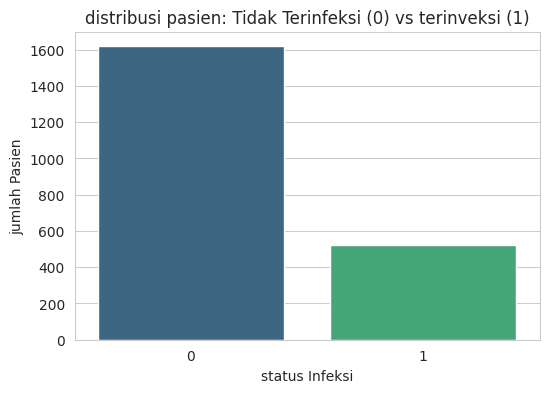

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x='infected', data=df, palette='viridis')
plt.title('distribusi pasien: Tidak Terinfeksi (0) vs terinveksi (1)', fontsize=12)
plt.xlabel('status Infeksi')
plt.ylabel('jumlah Pasien')
plt.show()

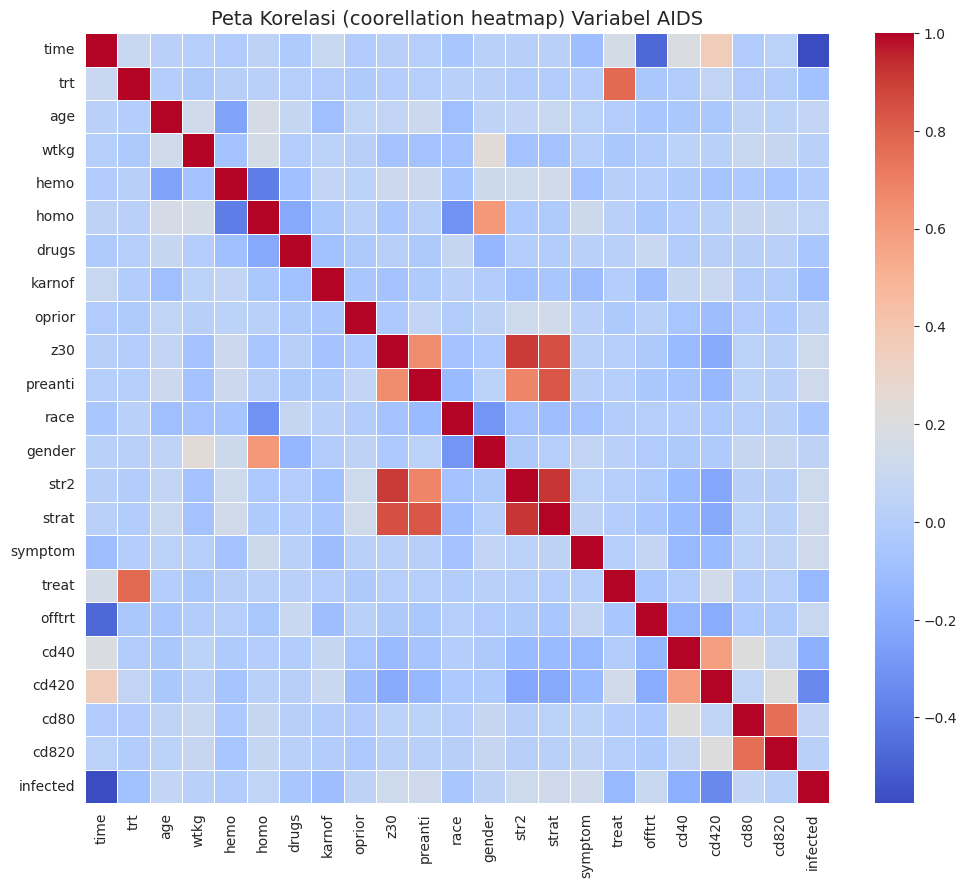

In [11]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Peta Korelasi (coorellation heatmap) Variabel AIDS', fontsize=14)
plt.show()

In [12]:
#memisahkan Fitur (x) dan Target (y)
X = df.drop('infected', axis=1) # semua kolom kecuali target
y = df['infected']              #kolom target saja

 Balancing Data


In [13]:
# memakai RandomOverSampler agar jumlah data 'sakit' dan 'sehat' seimbang
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(f"Data Awal: {X.shape}")
print(f"Data Setelah Balancing: {X_resampled.shape} (Jumlah kelas sekarang seimbang)")

Data Awal: (2139, 22)
Data Setelah Balancing: (3236, 22) (Jumlah kelas sekarang seimbang)


In [14]:
# splitting Data (80% Latih, 20% Uji)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [15]:
#agar angka 'umur' (misal 50) setara bobotnya dengan 'cd40' (misal 400)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 training Model Random Forest
 n_estimators=200 artinya  pakai 200 "pohon" keputusan

In [16]:
print("\sdg melatih model Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf_model.fit(X_train_scaled, y_train)

\sdg melatih model Random Forest...


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2838179772.py:1: SyntaxWarning: invalid escape sequence '\s'
  print("\sdg melatih model Random Forest...")


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

EVALUASI & VISUALISASI HASIL

In [17]:
#prediksi
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

In [18]:
print("\n" + "="*40)
print("HASIL EVALUASI MODEL")
print("="*40)
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi Model : {acc:.2%}") # Menampilkan persen
print("-" * 40)
print("Laporan Klasifikasi Rinci:")
print(classification_report(y_test, y_pred))


HASIL EVALUASI MODEL
Akurasi Model : 94.14%
----------------------------------------
Laporan Klasifikasi Rinci:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       331
           1       0.91      0.97      0.94       317

    accuracy                           0.94       648
   macro avg       0.94      0.94      0.94       648
weighted avg       0.94      0.94      0.94       648



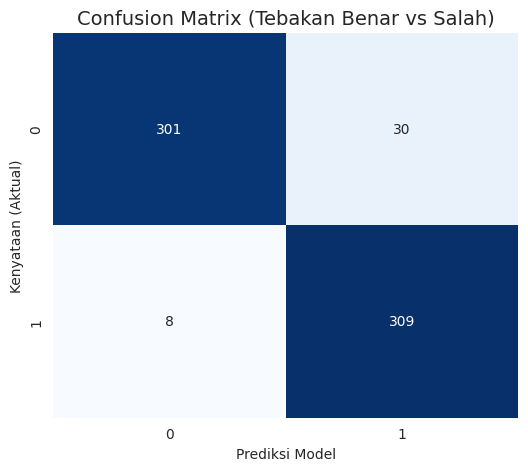

In [19]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Tebakan Benar vs Salah)', fontsize=14)
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan (Aktual)')
plt.show()

Visualisasi ROC-AUC Curve (Standar Medis)

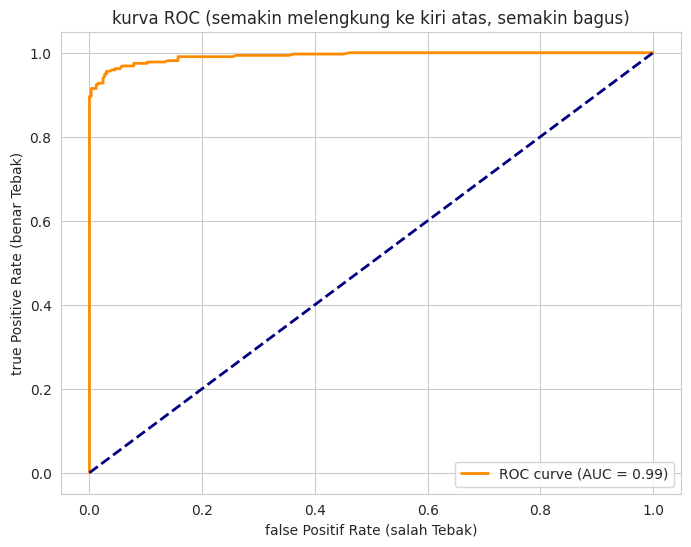

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('false Positif Rate (salah Tebak)')
plt.ylabel('true Positive Rate (benar Tebak)')
plt.title('kurva ROC (semakin melengkung ke kiri atas, semakin bagus)')
plt.legend(loc="lower right")
plt.show()

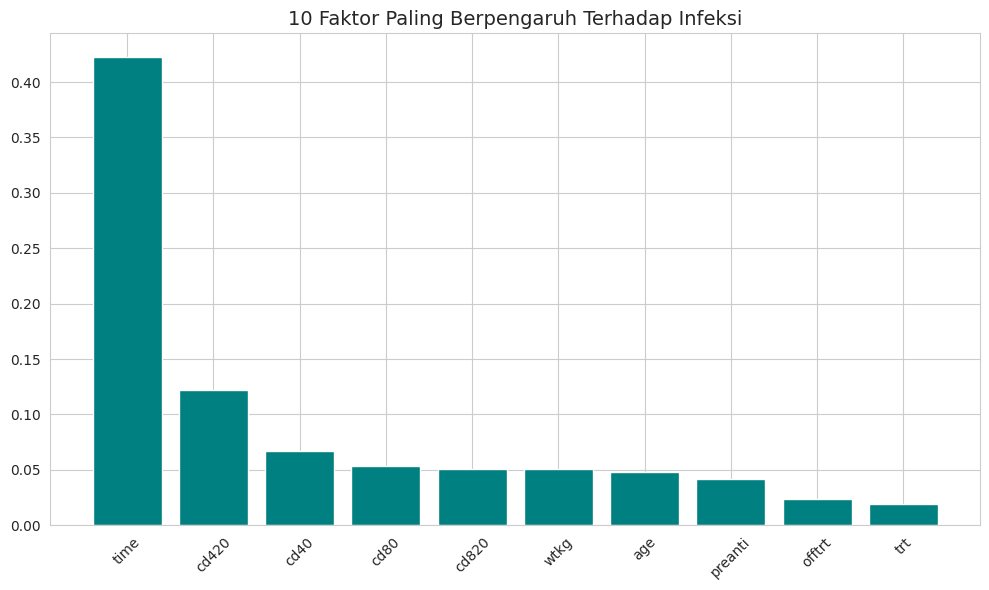

In [21]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_10 = 10

plt.figure(figsize=(10, 6))
plt.title('10 Faktor Paling Berpengaruh Terhadap Infeksi', fontsize=14)
plt.bar(range(top_10), importances[indices[:top_10]], align='center', color='teal')
plt.xticks(range(top_10), [X.columns[i] for i in indices[:top_10]], rotation=45)
plt.tight_layout()
plt.show()

In [22]:
import joblib
# menyimpan model ke file
joblib.dump(rf_model, 'model_uas_satria.joblib')
print("model berhasil disimpan!")

model berhasil disimpan!
